In [1]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
from scipy.signal import find_peaks_cwt as peakFinder
import numpy as np 
import matplotlib.pyplot as plt
from random import shuffle, randint
import pandas as pd
import sklearn
import datetime
%matplotlib inline

# Import and process data

In [156]:
def importData(filepath):
    ppt = np.genfromtxt(filepath)
    dppt = np.abs(np.diff(np.transpose(ppt)))
    print("Shape:", dppt[1:16,:].shape)
    return dppt[1:16,:]

illPat0 = importData("./inData/clean_ecg/ill/s0014lre.txt")
healthPat0 = importData("./inData/clean_ecg/health/s0303lre.txt")
illPat1 = importData("./inData/clean_ecg/ill/s0547_re.txt")
healthPat1 = importData("./inData/clean_ecg/health/s0306lre.txt")
testIll = importData("./inData/clean_ecg/ill/s0548_re.txt")
testHealth = importData("./inData/clean_ecg/health/s0302lre.txt")

Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 120011)
Shape: (15, 115199)
Shape: (15, 120011)
Shape: (15, 115199)


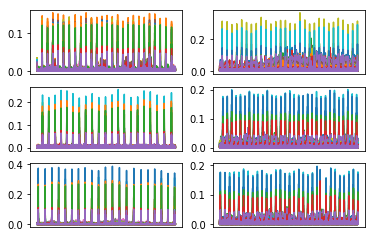

In [160]:
# Various plots...
fig, ((a,b),(c,d),(e,f)) = plt.subplots(3,2)
for i in np.arange(0,15):
    a.plot(healthPat0[i,0:20000])
    a.set_xticks([])
for i in np.arange(0,15):
    b.plot(illPat0[i,0:20000])
    b.set_xticks([])
for i in np.arange(0,15):
    c.plot(healthPat1[i,0:20000])
    c.set_xticks([])
for i in np.arange(0,15):
    d.plot(illPat1[i,0:20000])
    d.set_xticks([])
for i in np.arange(0,15):
    e.plot(testHealth[i,0:20000])
    e.set_xticks([])
for i in np.arange(0,15):
    f.plot(testIll[i,0:20000])
    f.set_xticks([])
    
dfhealthPat = np.append(healthPat0, healthPat1)
dfillPat = np.append(illPat0, illPat1)

In [167]:
def findAbove(arr, threshold, skip):
    """
    Return indices for values above threshhold in array, arr. Keep only first items in sequence.
    """
    inlst = []
    for index, item in enumerate(arr):
        if item >= threshold:
            inlst.append(index)
            
    return inlst[::skip]

def getSamples(arr, peakArr, buffer):
    """
    Get samples for array arr with buffer each side of peak indices, in peakArr.
    """
    sampledData = []
    for i in peakArr:
        if len(arr[i-buffer: i+buffer]) == buffer*2: # Check that all samples are same size
            sampledData.append(arr[i-buffer: i+buffer])
        
    return sampledData

def shuffle2Lst(list1, list2):
    """ 
    Shuffle two lists in similar ways.
    """
    list1_shuf = []
    list2_shuf = []
    index_shuf = np.arange(len(list1))
    shuffle(index_shuf)
    for i in index_shuf:
        list1_shuf.append(list1[i])
        list2_shuf.append(list2[i])
    return list1_shuf, list2_shuf

def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

def visualiseData(ecgData, classData, gridSize):
    """
    Plot labelled example data in a gridSize*gridSize grid.
    """
    fig, ax = plt.subplots(gridSize, gridSize)
    plt.suptitle("Labelled example data")
    r = randint(0,len(classData)-16)
    k = 0
    for i in np.arange(0,gridSize,1):
        for j in np.arange(0,gridSize,1):
            k = k + 1
            ax[i,j].plot(ecgData[r+k])
            ax[i,j].axis("off")
            ax[i,j].annotate(classData[r+k], xy=(0, 0), xycoords='axes points',\
                        size=10, ha='left', va='top')

def functionTown(illArr, healthArr, illThreshold, healthThreshold, skip, buffer, shuffle):
    """
    Return the processed ecgData and the classData (one-hot). Also return arrays of ill and healthy ppts.
    If shuffle is true, shuffle data.
    """
    illPeakArr = findAbove(illArr, illThreshold, skip)
    illSampled = getSamples(illArr, illPeakArr, buffer)
    healthPeakArr = findAbove(healthArr, healthThreshold, skip)
    healthSampled = getSamples(healthArr, healthPeakArr, buffer)
    
    print("ill samples", len(illSampled))
    print("healthy samples", len(healthSampled))
    
    classData = []
    for i in np.arange(0, len(illSampled), 1):
        classData.append(1)
    for i in np.arange(0, len(healthSampled), 1):
        classData.append(0)
    ecgData = illSampled + healthSampled
    
    if shuffle == True:
        classData, ecgData = shuffle2Lst(classData, ecgData)
        
    classDataOH = processClassData(classData)
    
    ecgData = np.reshape(np.concatenate(ecgData, axis=0), [len(ecgData), buffer*2, 1])
    
    return ecgData, classDataOH, classData
    
buffer = 150
healthThreshold = 0.06
illThreshold = 0.075
skip = 15

ecgData, classDataOH, classData = functionTown(dfillPat, dfhealthPat, illThreshold, healthThreshold, skip, buffer, True)

ill samples 2548
healthy samples 2673


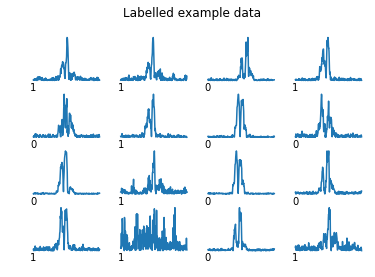

In [169]:
visualiseData(ecgData, classData, 4)

# Neural Network

In [170]:
sess = tf.InteractiveSession()
tf.reset_default_graph()
tflearn.initializations.normal()

# Input layer:
net = tflearn.layers.core.input_data(shape=[None, 300, 1])
    
# First layer:
net = tflearn.layers.conv.conv_1d(net, 32, 5, activation="leaky_relu")
net = tflearn.layers.conv.max_pool_1d(net, 2)

# Second layer:
net = tflearn.layers.conv.conv_1d(net, 64, 5, activation="leaky_relu")
net = tflearn.layers.conv.max_pool_1d(net, 2)

# Fully connected layer 1:
net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

# Dropout layer:
net = tflearn.layers.core.dropout(net, keep_prob=0.5)

# Output layer:
net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

net = tflearn.layers.estimator.regression(net, optimizer='adam', loss='categorical_crossentropy',\
                         learning_rate=0.00001)

In [171]:
model = tflearn.DNN(net, tensorboard_verbose=3)
model.fit(ecgData, classDataOH, n_epoch=20, validation_set=0.1, show_metric=True)

Training Step: 1480  | total loss: 0.27975
| Adam | epoch: 020 | loss: 0.27975 - acc: 0.9076 | val_loss: 0.24202 - val_acc: 0.9312 -- iter: 4698/4698
Training Step: 1480  | total loss: 0.27975
| Adam | epoch: 020 | loss: 0.27975 - acc: 0.9076 | val_loss: 0.24202 - val_acc: 0.9312 -- iter: 4698/4698
--


In [172]:
# Save model?
#now = datetime.datetime.now()
#model.save("./outData/models/cleanECG_"+now.isoformat()+"_.tflearn")

INFO:tensorflow:././outData/models/cleanECG_2017-02-15T16:00:13.514595_.tflearn is not in all_model_checkpoint_paths. Manually adding it.


In [181]:
testIll = np.hstack(testIll)
testHealth = np.hstack(testHealth)

tbuffer = 150
thealthThreshold = 0.1
tillThreshold = 0.1
tskip = 1

tecgData, tclassDataOH, tclassData = functionTown(testIll, testHealth, tillThreshold, thealthThreshold, tskip, tbuffer, False)

ill samples 7208
healthy samples 5958


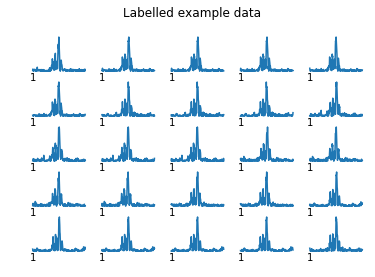

In [185]:
visualiseData(tecgData, tclassData, 5)

In [184]:
#model.load("./outData/models/cleanECG_2017-02-14T23:10:17.479693_.tflearn")
tecgData = np.reshape(np.concatenate(tecgData, axis=0), [len(tecgData), tbuffer*2, 1])
print("Sensitivity:", model.evaluate(tecgData[7208:], tclassDataOH[7208:]), "Specifity:",\
    model.evaluate(tecgData[:7208], tclassDataOH[:7208]),\
    "Accuracy:", model.evaluate(tecgData, tclassDataOH))

Sensitivity: [0.90483383653787364] Specifity: [0.60862930084306843] Accuracy: [0.74267051504427184]
